# Import Dataset

In [11]:
import pandas as pd
import numpy as np
import os
import glob
from tqdm import tqdm
from sklearn.model_selection import train_test_split as tts
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
import random
from PIL import Image

import torch
from torch import nn
from torchvision import datasets
from torch.utils.data import Dataset, DataLoader

In [8]:
!pip install -q kaggle

In [14]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"saifswelem","key":"3d3864d906cc00ed0a0f9bd11a6322b7"}'}

In [15]:
!mkdir -p ~/.kaggle

In [16]:
!mkdir /content/Dataset

In [17]:
!cp kaggle.json ~/.kaggle/

In [18]:
! chmod 600 ~/.kaggle/kaggle.json

In [19]:
import os
os.chdir('/content/Dataset')

In [20]:
!kaggle datasets download -d noamsegal/affectnet-training-data

 95% 300M/314M [00:03<00:00, 79.2MB/s]
100% 314M/314M [00:03<00:00, 84.7MB/s]


In [ ]:
!unzip affectnet-training-data.zip

In [ ]:
pip install deepface

In [16]:
from deepface import DeepFace

24-01-07 14:59:54 - Directory /root/.deepface created
24-01-07 14:59:54 - Directory /root/.deepface/weights created


In [22]:
from deepface import DeepFace
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import os
from os.path import join
import random
import numpy as np
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Conv2D, Dropout, BatchNormalization, Flatten, Dense, MaxPool2D
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint


24-01-07 19:22:47 - Directory /root/.deepface created
24-01-07 19:22:47 - Directory /root/.deepface/weights created


In [24]:
path = ('/content/Dataset/')
file = (path + 'labels.csv')
df = pd.read_csv(file)
df.head()

,Unnamed: 0,pth,label,relFCs
0,0,anger/image0000006.jpg,surprise,0.873142
1,1,anger/image0000060.jpg,anger,0.852311
2,2,anger/image0000061.jpg,anger,0.800957
3,3,anger/image0000066.jpg,disgust,0.843079
4,4,anger/image0000106.jpg,anger,0.849108


# Preprocess

## Deepface

In [25]:
# Function to predict facial expression using DeepFace
def predict_facial_expression(image_path):
    result = DeepFace.analyze(img_path=image_path, actions=['emotion'], enforce_detection=False)
    if 'dominant_emotion' in result[0]:
        dominant_emotion = result[0]['dominant_emotion']
        return dominant_emotion
    else:
        print(f"Face could not be detected in {image_path}.")
        return "Unknown"


24-01-07 19:23:04 - facial_expression_model_weights.h5 will be downloaded...


Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/facial_expression_model_weights.h5
To: /root/.deepface/weights/facial_expression_model_weights.h5
100%|██████████| 5.98M/5.98M [00:00<00:00, 21.6MB/s]


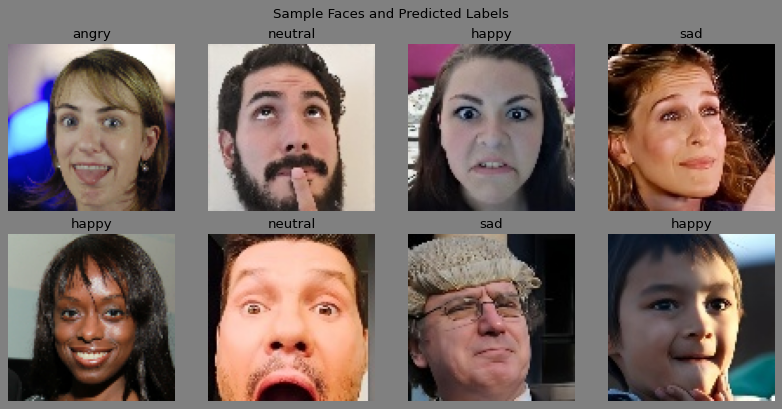

In [26]:
fig, axs = plt.subplots(2, 4, sharey=True, constrained_layout=True, num=None,
                        figsize=(10, 5), dpi=80, facecolor='gray', edgecolor='k')
fig.suptitle("Sample Faces and Predicted Labels")
axs = axs.flatten()

for i in range(8):
    idx = random.randint(0, len(df) - 1)  # randomly select an index
    img_path = path + df['pth'][idx]
    img = cv2.imread(img_path)  # read image
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # convert to BGR to RGB
    axs[i].imshow(img)

    # Predict facial expression using DeepFace
    predicted_expression = predict_facial_expression(img_path)

    axs[i].set_title(predicted_expression)
    axs[i].axis('off')


## Preprocess

In [27]:
# 1. define functions to pre-process and load images into arrays / label from folders


import cv2
import numpy as np
from keras.utils import to_categorical
import os

INPUT_PATH = "/content/Dataset"
EMOTIONS = [f.name for f in os.scandir(INPUT_PATH) if f.is_dir()]
IMAGE_SIZE = (96, 96)

print(EMOTIONS)

def image_generator(input_path, emotions, image_size):
    for index, emotion in enumerate(emotions):
        for filename in os.listdir(os.path.join(input_path, emotion)):
            img = cv2.imread(os.path.join(input_path, emotion, filename))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
            #img = cv2.resize(img, image_size)
            #img = img.astype('float32') / 255.0  # Normilize
            yield img, index

def load_images(input_path, emotions, image_size):
    X, y = [], []
    for img, label in image_generator(input_path, emotions, image_size):
        X.append(img)
        y.append(label)
    X = np.array(X)
    y = to_categorical(np.array(y))

    return X, y

['happy', 'contempt', 'disgust', 'neutral', 'surprise', 'sad', 'fear', 'anger']


In [ ]:

# Preprocess the data using DeepFace predictions
X = []
y = []

total_images = len(df)
progress_interval = total_images // 100  # Display progress every 1% of images

for idx, row in df.iterrows():
    img_path = path + row['pth']
    predicted_expression = predict_facial_expression(img_path).lower()  # Convert to lowercase

    # Handle special case for 'angry' to 'anger'
    if predicted_expression == 'angry':
        predicted_expression = 'anger'

    img = cv2.imread(img_path)  # read image
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # convert to BGR to RGB
    X.append(img)
    y.append(EMOTIONS.index(predicted_expression))

    # Display progress
    if idx % progress_interval == 0 or idx == total_images - 1:
        progress_percentage = (idx + 1) / total_images * 100
        print(f"Preprocessing progress: {progress_percentage:.2f}%")

X = np.array(X)
y = to_categorical(np.array(y))

# Train test split pre-processed data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)




In [ ]:
# choose a random image index
idx = np.random.randint(len(X))

# display the image and its corresponding label from arrays
plt.imshow(X[idx])
plt.title(EMOTIONS[np.argmax(y[idx])])
plt.axis('off')  # remove the grid
plt.show()


In [ ]:
# Train test split pre-processed data

from sklearn.model_selection import StratifiedShuffleSplit, train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)


## Save to Drive

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

# Save the preprocessed data to Google Drive
np.savez('/content/gdrive/MyDrive/preprocessed_data.npz', X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test)


## Load From Drive

In [1]:
from google.colab import drive
import numpy as np

# Mount Google Drive
drive.mount('/content/gdrive')

# Load preprocessed data from Google Drive
data = np.load('/content/gdrive/MyDrive/preprocessed_data.npz')
X_train_loaded, X_test_loaded, y_train_loaded, y_test_loaded = data['X_train'], data['X_test'], data['y_train'], data['y_test']

# Verify the loaded data
print("Loaded data shapes:")
print("X_train:", X_train_loaded.shape)
print("X_test:", X_test_loaded.shape)
print("y_train:", y_train_loaded.shape)
print("y_test:", y_test_loaded.shape)
# Get the input shape from the loaded data
input_shape = X_train_loaded.shape[1:]

Mounted at /content/gdrive
Loaded data shapes:
X_train: (22540, 96, 96, 3)
X_test: (5635, 96, 96, 3)
y_train: (22540, 9)
y_test: (5635, 9)


# Train with 8 features

In [2]:

import cv2
from skimage import exposure
import numpy as np


def custom_visual_enhancements8(img):
    # # Convert the image to 8-bit unsigned integer format
    # img = (img * 255).astype(np.uint8)



    # Gamma Correction
    gamma = 1.5
    img = np.power(img / float(np.max(img)), gamma)

    # Sharpness Adjustment
    alpha = 1.5
    img = cv2.addWeighted(img, alpha, cv2.GaussianBlur(img, (0, 0), 5), 1 - alpha, 0)

    # Convert back to 8-bit unsigned integer format
    img = np.clip(img, 0, 1)
    img = (img * 255).astype(np.uint8)

    # Convert to HSV color space
    img_hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

    # Separate the channels
    h, s, v = cv2.split(img_hsv)

    # Histogram Equalization on the Value (V) channel
    v = cv2.equalizeHist(v)

    # Merge the channels back together
    img_hsv = cv2.merge([h, s, v])

    # Convert back to RGB
    img = cv2.cvtColor(img_hsv, cv2.COLOR_HSV2RGB)

    # Saturation Adjustment
    saturation_factor = 0.5
    img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV).astype(float)
    img_hsv[:, :, 1] *= saturation_factor
    img_hsv[:, :, 1] = np.clip(img_hsv[:, :, 1], 0, 255)
    img_hsv = img_hsv.astype(np.uint8)

    # Color Jittering
    color_jitter = 2
    img = np.clip(img + np.random.randint(-color_jitter, color_jitter + 1), 0, 255).astype(np.uint8)


    # Brightness Adjustment
    brightness_factor = 50
    img = cv2.convertScaleAbs(img, beta=brightness_factor)

    # Gaussian Blur
    img = cv2.GaussianBlur(img, (1, 1), 0)




    # Rotation
    angle = np.random.uniform(-10, 10)
    rows, cols, _ = img.shape
    M = cv2.getRotationMatrix2D((cols / 2, rows / 2), angle, 1)
    img = cv2.warpAffine(img, M, (cols, rows))



    return img


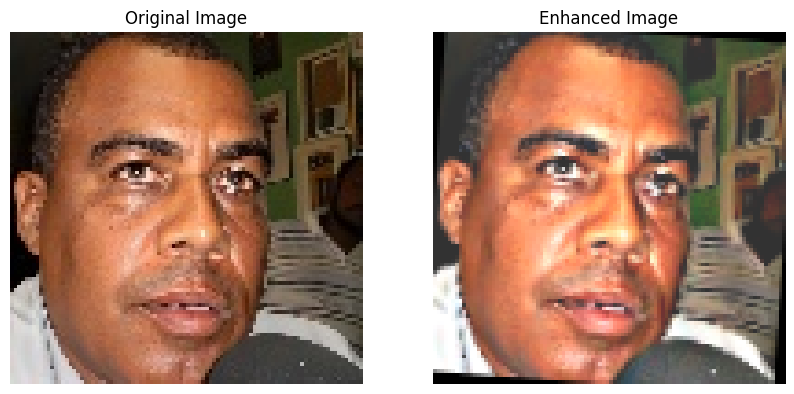

In [4]:
import matplotlib.pyplot as plt

# Choose a random image index from your preprocessed data
sample_idx = np.random.randint(len(X_train_loaded))

# Retrieve the original and enhanced images
original_image = X_train_loaded[sample_idx]
enhanced_image = custom_visual_enhancements8(original_image.copy())  # Make a copy to avoid modifying the original

# Display the original and enhanced images side by side
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(original_image)
axs[0].set_title("Original Image")
axs[0].axis('off')

axs[1].imshow(enhanced_image)
axs[1].set_title("Enhanced Image")
axs[1].axis('off')

plt.show()


In [5]:

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

# Create an instance of ImageDataGenerator for data augmentation with visual enhancements
datagen8 = ImageDataGenerator(
    preprocessing_function=custom_visual_enhancements8
)



In [6]:
train_generator = datagen8.flow(X_train_loaded, y_train_loaded, batch_size=64)
test_generator = datagen8.flow(X_test_loaded, y_test_loaded, batch_size=64)

In [7]:
print(X_train_loaded.shape)

(22540, 96, 96, 3)


In [8]:
from keras.models import Sequential
from keras.layers import Conv2D, Dropout, BatchNormalization, Flatten, Dense, MaxPool2D
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam

model_2 = Sequential()

model_2.add(Conv2D(32, (3,3), activation="selu", input_shape=input_shape))
model_2.add(BatchNormalization())
model_2.add(MaxPool2D(pool_size=(2,2)))
model_2.add(Dropout(0.25))

model_2.add(Conv2D(64, (3,3), activation="selu"))
model_2.add(BatchNormalization())
model_2.add(Conv2D(64, (3,3), activation="selu"))
model_2.add(BatchNormalization())
model_2.add(MaxPool2D(pool_size=(2,2)))
model_2.add(Dropout(0.25))

model_2.add(Conv2D(128, (3,3), activation="selu"))
model_2.add(BatchNormalization())
model_2.add(Conv2D(128, (3,3), activation="selu"))
model_2.add(BatchNormalization())
model_2.add(MaxPool2D(pool_size=(2,2)))
model_2.add(Dropout(0.25))

model_2.add(Conv2D(256, (3,3), activation="selu"))
model_2.add(BatchNormalization())
model_2.add(Conv2D(256, (3,3), activation="selu"))
model_2.add(BatchNormalization())
model_2.add(MaxPool2D(pool_size=(2,2)))
model_2.add(Dropout(0.25))

model_2.add(Flatten())
model_2.add(Dense(128, activation='selu', kernel_regularizer=l2(0.01)))
model_2.add(BatchNormalization())
model_2.add(Dropout(0.5))
model_2.add(Dense(9, activation='softmax'))

model_2.compile(optimizer = Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

model_2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 94, 94, 32)        896       
                                                                 
 batch_normalization (Batch  (None, 94, 94, 32)        128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 47, 47, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 47, 47, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 45, 45, 64)        18496     
                                                                 
 batch_normalization_1 (Bat  (None, 45, 45, 64)        2

In [9]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

history = model_2.fit(train_generator,
                      epochs=25,
                      validation_data=test_generator,
                      callbacks=[EarlyStopping(patience=10, monitor='val_loss', mode='min'),
                                 ReduceLROnPlateau(patience=2, verbose=1),
                                 ModelCheckpoint('best_model.h5',
                                                 save_best_only=True,
                                                 save_weights_only=True,
                                                 monitor='val_accuracy',
                                                 mode='max')],
                      verbose=1)



Epoch 1/25
353/353 [==============================] - 87s 212ms/step - loss: 3.4455 - accuracy: 0.3018 - val_loss: 2.2555 - val_accuracy: 0.4000 - lr: 0.0010
Epoch 2/25
353/353 [==============================] - 61s 173ms/step - loss: 1.8393 - accuracy: 0.4271 - val_loss: 1.6113 - val_accuracy: 0.4421 - lr: 0.0010
Epoch 3/25
353/353 [==============================] - 59s 167ms/step - loss: 1.4999 - accuracy: 0.4751 - val_loss: 1.4508 - val_accuracy: 0.4804 - lr: 0.0010
Epoch 4/25
353/353 [==============================] - 63s 179ms/step - loss: 1.4094 - accuracy: 0.4958 - val_loss: 1.3736 - val_accuracy: 0.5052 - lr: 0.0010
Epoch 5/25
353/353 [==============================] - 61s 172ms/step - loss: 1.3791 - accuracy: 0.5072 - val_loss: 1.3994 - val_accuracy: 0.4957 - lr: 0.0010
Epoch 6/25
353/353 [==============================] - 61s 172ms/step - loss: 1.3499 - accuracy: 0.5181 - val_loss: 1.3276 - val_accuracy: 0.5256 - lr: 0.0010
Epoch 7/25
353/353 [==============================] 

In [14]:
# Save the entire model to a file
model_2.save('/content/gdrive/MyDrive/trained8_model2.h5')
model_2.save('/content/gdrive/MyDrive/trained8_model2.keras')

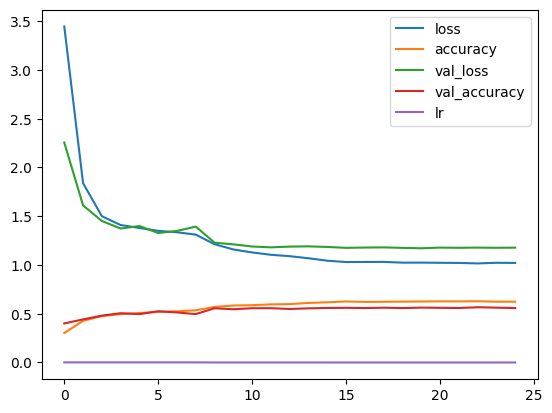

In [16]:
import pandas as pd

pd.DataFrame(history.history).plot();

# Train with 4 Features
-Rotation
-Jittering
-Blur
-Sharpness


In [2]:

import cv2
from skimage import exposure
import numpy as np


def custom_visual_enhancements4(img):
    # # Convert the image to 8-bit unsigned integer format
    # img = (img * 255).astype(np.uint8)



    # Gamma Correction
    gamma = 1.5
    img = np.power(img / float(np.max(img)), gamma)


    # Convert back to 8-bit unsigned integer format
    img = np.clip(img, 0, 1)
    img = (img * 255).astype(np.uint8)

    # Convert to HSV color space
    img_hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

    # Separate the channels
    h, s, v = cv2.split(img_hsv)

    # Histogram Equalization on the Value (V) channel
    v = cv2.equalizeHist(v)

    # Merge the channels back together
    img_hsv = cv2.merge([h, s, v])

    # Convert back to RGB
    img = cv2.cvtColor(img_hsv, cv2.COLOR_HSV2RGB)

    # Saturation Adjustment
    saturation_factor = 0.5
    img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV).astype(float)
    img_hsv[:, :, 1] *= saturation_factor
    img_hsv[:, :, 1] = np.clip(img_hsv[:, :, 1], 0, 255)
    img_hsv = img_hsv.astype(np.uint8)


    # Brightness Adjustment
    brightness_factor = 50
    img = cv2.convertScaleAbs(img, beta=brightness_factor)





    return img


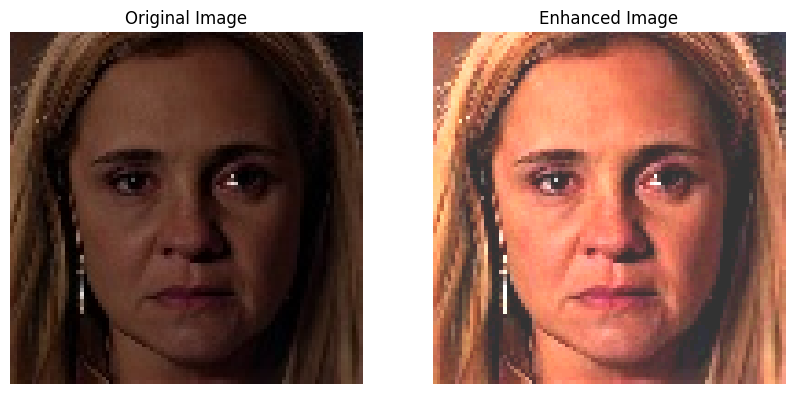

In [3]:
import matplotlib.pyplot as plt

# Choose a random image index from your preprocessed data
sample_idx = np.random.randint(len(X_train_loaded))

# Retrieve the original and enhanced images
original_image = X_train_loaded[sample_idx]
enhanced_image = custom_visual_enhancements4(original_image.copy())  # Make a copy to avoid modifying the original

# Display the original and enhanced images side by side
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(original_image)
axs[0].set_title("Original Image")
axs[0].axis('off')

axs[1].imshow(enhanced_image)
axs[1].set_title("Enhanced Image")
axs[1].axis('off')

plt.show()


In [4]:
# Create an instance of ImageDataGenerator for data augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

# Create an instance of ImageDataGenerator for data augmentation with visual enhancements
datagen4 = ImageDataGenerator(
    preprocessing_function=custom_visual_enhancements4
)


In [5]:
train_generator = datagen4.flow(X_train_loaded, y_train_loaded, batch_size=64)
test_generator = datagen4.flow(X_test_loaded, y_test_loaded, batch_size=64)

In [6]:
from keras.models import Sequential
from keras.layers import Conv2D, Dropout, BatchNormalization, Flatten, Dense, MaxPool2D
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam

model_3 = Sequential()

model_3.add(Conv2D(32, (3,3), activation="selu", input_shape=input_shape))
model_3.add(BatchNormalization())
model_3.add(MaxPool2D(pool_size=(2,2)))
model_3.add(Dropout(0.25))

model_3.add(Conv2D(64, (3,3), activation="selu"))
model_3.add(BatchNormalization())
model_3.add(Conv2D(64, (3,3), activation="selu"))
model_3.add(BatchNormalization())
model_3.add(MaxPool2D(pool_size=(2,2)))
model_3.add(Dropout(0.25))

model_3.add(Conv2D(128, (3,3), activation="selu"))
model_3.add(BatchNormalization())
model_3.add(Conv2D(128, (3,3), activation="selu"))
model_3.add(BatchNormalization())
model_3.add(MaxPool2D(pool_size=(2,2)))
model_3.add(Dropout(0.25))

model_3.add(Conv2D(256, (3,3), activation="selu"))
model_3.add(BatchNormalization())
model_3.add(Conv2D(256, (3,3), activation="selu"))
model_3.add(BatchNormalization())
model_3.add(MaxPool2D(pool_size=(2,2)))
model_3.add(Dropout(0.25))

model_3.add(Flatten())
model_3.add(Dense(128, activation='selu', kernel_regularizer=l2(0.01)))
model_3.add(BatchNormalization())
model_3.add(Dropout(0.5))
model_3.add(Dense(9, activation='softmax'))

model_3.compile(optimizer = Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

model_3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 94, 94, 32)        896       
                                                                 
 batch_normalization (Batch  (None, 94, 94, 32)        128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 47, 47, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 47, 47, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 45, 45, 64)        18496     
                                                                 
 batch_normalization_1 (Bat  (None, 45, 45, 64)        2

In [7]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

history = model_3.fit(train_generator,
                      epochs=25,
                      validation_data=test_generator,
                      callbacks=[EarlyStopping(patience=10, monitor='val_loss', mode='min'),
                                 ReduceLROnPlateau(patience=2, verbose=1),
                                 ModelCheckpoint('best_model.h5',
                                                 save_best_only=True,
                                                 save_weights_only=True,
                                                 monitor='val_accuracy',
                                                 mode='max')],
                      verbose=1)



Epoch 1/25
353/353 [==============================] - 59s 128ms/step - loss: 3.3903 - accuracy: 0.3100 - val_loss: 2.1087 - val_accuracy: 0.4254 - lr: 0.0010
Epoch 2/25
353/353 [==============================] - 44s 124ms/step - loss: 1.8147 - accuracy: 0.4439 - val_loss: 1.5091 - val_accuracy: 0.4784 - lr: 0.0010
Epoch 3/25
353/353 [==============================] - 47s 133ms/step - loss: 1.4748 - accuracy: 0.4877 - val_loss: 1.4558 - val_accuracy: 0.4800 - lr: 0.0010
Epoch 4/25
353/353 [==============================] - 46s 130ms/step - loss: 1.3901 - accuracy: 0.5118 - val_loss: 1.3687 - val_accuracy: 0.5083 - lr: 0.0010
Epoch 5/25
353/353 [==============================] - 48s 135ms/step - loss: 1.3524 - accuracy: 0.5218 - val_loss: 1.4424 - val_accuracy: 0.4829 - lr: 0.0010
Epoch 6/25
353/353 [==============================] - 47s 132ms/step - loss: 1.3254 - accuracy: 0.5390 - val_loss: 1.3336 - val_accuracy: 0.5274 - lr: 0.0010
Epoch 7/25
353/353 [==============================] 

In [9]:
# Save the entire model to a file
model_3.save('/content/gdrive/MyDrive/trained4_model3.h5')
model_3.save('/content/gdrive/MyDrive/trained4_model3.keras')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


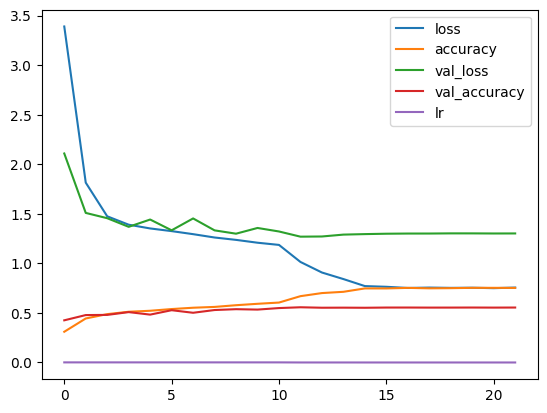

In [11]:
import pandas as pd
pd.DataFrame(history.history).plot();

# Train with 2 Features
+Gamme + Brightness

In [14]:

import cv2
from skimage import exposure
import numpy as np


def custom_visual_enhancements2(img):
    # # Convert the image to 8-bit unsigned integer format
    # img = (img * 255).astype(np.uint8)



    # Gamma Correction
    gamma = 1.5
    img = np.power(img / float(np.max(img)), gamma)


    # Convert back to 8-bit unsigned integer format
    img = np.clip(img, 0, 1)
    img = (img * 255).astype(np.uint8)



    # Brightness Adjustment
    brightness_factor = 50
    img = cv2.convertScaleAbs(img, beta=brightness_factor)





    return img


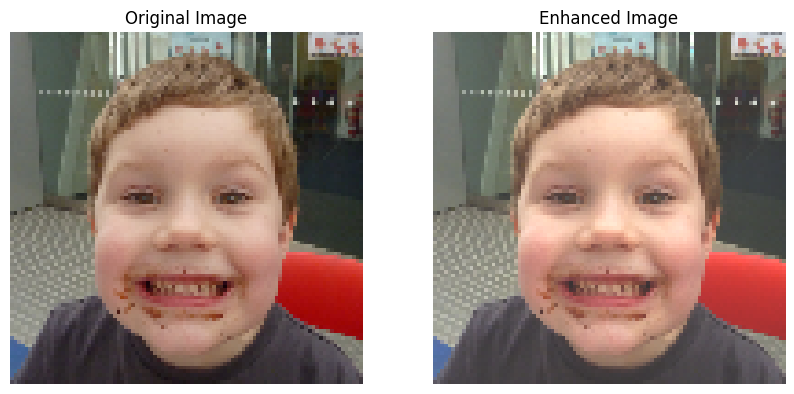

In [15]:
import matplotlib.pyplot as plt

# Choose a random image index from your preprocessed data
sample_idx = np.random.randint(len(X_train_loaded))

# Retrieve the original and enhanced images
original_image = X_train_loaded[sample_idx]
enhanced_image = custom_visual_enhancements2(original_image.copy())  # Make a copy to avoid modifying the original

# Display the original and enhanced images side by side
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(original_image)
axs[0].set_title("Original Image")
axs[0].axis('off')

axs[1].imshow(enhanced_image)
axs[1].set_title("Enhanced Image")
axs[1].axis('off')

plt.show()

In [16]:
# Create an instance of ImageDataGenerator for data augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

# Create an instance of ImageDataGenerator for data augmentation with visual enhancements
datagen2 = ImageDataGenerator(
    preprocessing_function=custom_visual_enhancements2
)


In [17]:
train_generator = datagen2.flow(X_train_loaded, y_train_loaded, batch_size=64)
test_generator = datagen2.flow(X_test_loaded, y_test_loaded, batch_size=64)

In [18]:
from keras.models import Sequential
from keras.layers import Conv2D, Dropout, BatchNormalization, Flatten, Dense, MaxPool2D
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam

model_4 = Sequential()

model_4.add(Conv2D(32, (3,3), activation="selu", input_shape=input_shape))
model_4.add(BatchNormalization())
model_4.add(MaxPool2D(pool_size=(2,2)))
model_4.add(Dropout(0.25))

model_4.add(Conv2D(64, (3,3), activation="selu"))
model_4.add(BatchNormalization())
model_4.add(Conv2D(64, (3,3), activation="selu"))
model_4.add(BatchNormalization())
model_4.add(MaxPool2D(pool_size=(2,2)))
model_4.add(Dropout(0.25))

model_4.add(Conv2D(128, (3,3), activation="selu"))
model_4.add(BatchNormalization())
model_4.add(Conv2D(128, (3,3), activation="selu"))
model_4.add(BatchNormalization())
model_4.add(MaxPool2D(pool_size=(2,2)))
model_4.add(Dropout(0.25))

model_4.add(Conv2D(256, (3,3), activation="selu"))
model_4.add(BatchNormalization())
model_4.add(Conv2D(256, (3,3), activation="selu"))
model_4.add(BatchNormalization())
model_4.add(MaxPool2D(pool_size=(2,2)))
model_4.add(Dropout(0.25))

model_4.add(Flatten())
model_4.add(Dense(128, activation='selu', kernel_regularizer=l2(0.01)))
model_4.add(BatchNormalization())
model_4.add(Dropout(0.5))
model_4.add(Dense(9, activation='softmax'))

model_4.compile(optimizer = Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

model_4.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 94, 94, 32)        896       
                                                                 
 batch_normalization_16 (Ba  (None, 94, 94, 32)        128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 47, 47, 32)        0         
 g2D)                                                            
                                                                 
 dropout_10 (Dropout)        (None, 47, 47, 32)        0         
                                                                 
 conv2d_15 (Conv2D)          (None, 45, 45, 64)        18496     
                                                                 
 batch_normalization_17 (Ba  (None, 45, 45, 64)       

In [19]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

history = model_4.fit(train_generator,
                      epochs=25,
                      validation_data=test_generator,
                      callbacks=[EarlyStopping(patience=10, monitor='val_loss', mode='min'),
                                 ReduceLROnPlateau(patience=2, verbose=1),
                                 ModelCheckpoint('best_model.h5',
                                                 save_best_only=True,
                                                 save_weights_only=True,
                                                 monitor='val_accuracy',
                                                 mode='max')],
                      verbose=1)


Epoch 1/25
353/353 [==============================] - 54s 135ms/step - loss: 3.4342 - accuracy: 0.3169 - val_loss: 2.0958 - val_accuracy: 0.4209 - lr: 0.0010
Epoch 2/25
353/353 [==============================] - 38s 107ms/step - loss: 1.8159 - accuracy: 0.4499 - val_loss: 1.5137 - val_accuracy: 0.4756 - lr: 0.0010
Epoch 3/25
353/353 [==============================] - 32s 90ms/step - loss: 1.4512 - accuracy: 0.4971 - val_loss: 1.4199 - val_accuracy: 0.4976 - lr: 0.0010
Epoch 4/25
353/353 [==============================] - 32s 89ms/step - loss: 1.3556 - accuracy: 0.5189 - val_loss: 1.3426 - val_accuracy: 0.5194 - lr: 0.0010
Epoch 5/25
353/353 [==============================] - 32s 90ms/step - loss: 1.3119 - accuracy: 0.5378 - val_loss: 1.3177 - val_accuracy: 0.5297 - lr: 0.0010
Epoch 6/25
353/353 [==============================] - 35s 100ms/step - loss: 1.2857 - accuracy: 0.5485 - val_loss: 1.3837 - val_accuracy: 0.5249 - lr: 0.0010
Epoch 7/25
353/353 [==============================] - 3

In [25]:
# Save the entire model to a file
model_4.save('/content/gdrive/MyDrive/trained2_model4.h5')
model_4.save('/content/gdrive/MyDrive/trained2_model4.keras')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


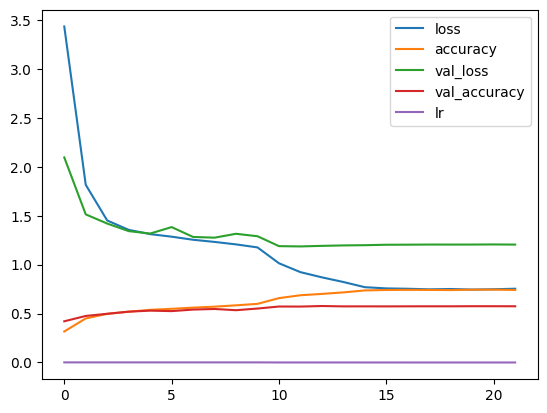

In [21]:
pd.DataFrame(history.history).plot();

# Train with 0 Features

In [3]:

import cv2
from skimage import exposure
import numpy as np


def custom_visual_enhancements(img):
    return img


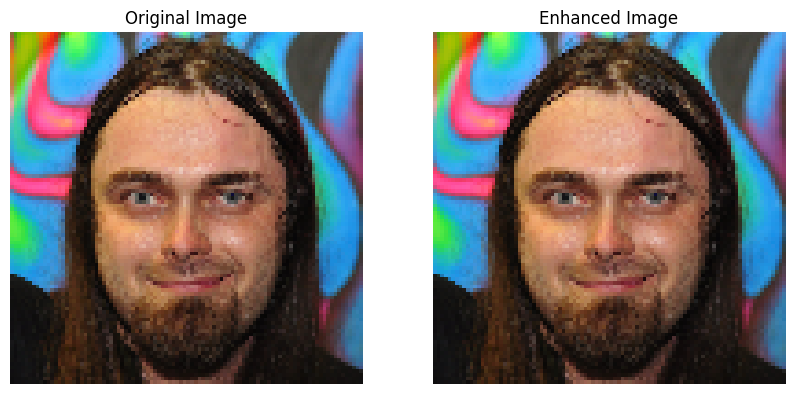

In [4]:
import matplotlib.pyplot as plt

# Choose a random image index from your preprocessed data
sample_idx = np.random.randint(len(X_train_loaded))

# Retrieve the original and enhanced images
original_image = X_train_loaded[sample_idx]
enhanced_image = custom_visual_enhancements(original_image.copy())  # Make a copy to avoid modifying the original

# Display the original and enhanced images side by side
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(original_image)
axs[0].set_title("Original Image")
axs[0].axis('off')

axs[1].imshow(enhanced_image)
axs[1].set_title("Enhanced Image")
axs[1].axis('off')

plt.show()

In [5]:
# Create an instance of ImageDataGenerator for data augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

# Create an instance of ImageDataGenerator for data augmentation with visual enhancements
datagen = ImageDataGenerator(
    preprocessing_function=custom_visual_enhancements
)


In [6]:
train_generator = datagen.flow(X_train_loaded, y_train_loaded, batch_size=64)
test_generator = datagen.flow(X_test_loaded, y_test_loaded, batch_size=64)

In [7]:
from keras.models import Sequential
from keras.layers import Conv2D, Dropout, BatchNormalization, Flatten, Dense, MaxPool2D
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam

model_5 = Sequential()

model_5.add(Conv2D(32, (3,3), activation="selu", input_shape=input_shape))
model_5.add(BatchNormalization())
model_5.add(MaxPool2D(pool_size=(2,2)))
model_5.add(Dropout(0.25))

model_5.add(Conv2D(64, (3,3), activation="selu"))
model_5.add(BatchNormalization())
model_5.add(Conv2D(64, (3,3), activation="selu"))
model_5.add(BatchNormalization())
model_5.add(MaxPool2D(pool_size=(2,2)))
model_5.add(Dropout(0.25))

model_5.add(Conv2D(128, (3,3), activation="selu"))
model_5.add(BatchNormalization())
model_5.add(Conv2D(128, (3,3), activation="selu"))
model_5.add(BatchNormalization())
model_5.add(MaxPool2D(pool_size=(2,2)))
model_5.add(Dropout(0.25))

model_5.add(Conv2D(256, (3,3), activation="selu"))
model_5.add(BatchNormalization())
model_5.add(Conv2D(256, (3,3), activation="selu"))
model_5.add(BatchNormalization())
model_5.add(MaxPool2D(pool_size=(2,2)))
model_5.add(Dropout(0.25))

model_5.add(Flatten())
model_5.add(Dense(128, activation='selu', kernel_regularizer=l2(0.01)))
model_5.add(BatchNormalization())
model_5.add(Dropout(0.5))
model_5.add(Dense(9, activation='softmax'))

model_5.compile(optimizer = Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

model_5.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 94, 94, 32)        896       
                                                                 
 batch_normalization_8 (Bat  (None, 94, 94, 32)        128       
 chNormalization)                                                
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 47, 47, 32)        0         
 g2D)                                                            
                                                                 
 dropout_5 (Dropout)         (None, 47, 47, 32)        0         
                                                                 
 conv2d_8 (Conv2D)           (None, 45, 45, 64)        18496     
                                                                 
 batch_normalization_9 (Bat  (None, 45, 45, 64)       

In [8]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

history = model_5.fit(train_generator,
                      epochs=25,
                      validation_data=test_generator,
                      callbacks=[EarlyStopping(patience=10, monitor='val_loss', mode='min'),
                                 ReduceLROnPlateau(patience=2, verbose=1),
                                 ModelCheckpoint('best_model.h5',
                                                 save_best_only=True,
                                                 save_weights_only=True,
                                                 monitor='val_accuracy',
                                                 mode='max')],
                      verbose=1)


Epoch 1/25
353/353 [==============================] - 33s 53ms/step - loss: 3.5170 - accuracy: 0.3128 - val_loss: 2.2077 - val_accuracy: 0.4206 - lr: 0.0010
Epoch 2/25
353/353 [==============================] - 15s 42ms/step - loss: 1.8228 - accuracy: 0.4570 - val_loss: 1.5433 - val_accuracy: 0.4774 - lr: 0.0010
Epoch 3/25
353/353 [==============================] - 13s 36ms/step - loss: 1.4363 - accuracy: 0.5059 - val_loss: 1.3677 - val_accuracy: 0.5175 - lr: 0.0010
Epoch 4/25
353/353 [==============================] - 12s 34ms/step - loss: 1.3437 - accuracy: 0.5300 - val_loss: 1.3719 - val_accuracy: 0.5187 - lr: 0.0010
Epoch 5/25
352/353 [============================>.] - ETA: 0s - loss: 1.3021 - accuracy: 0.5436
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
353/353 [==============================] - 12s 33ms/step - loss: 1.3015 - accuracy: 0.5438 - val_loss: 1.4027 - val_accuracy: 0.4972 - lr: 0.0010
Epoch 6/25
353/353 [==============================] -

In [10]:
# Save the entire model to a file
model_5.save('/content/gdrive/MyDrive/trained0_model5.h5')
model_5.save('/content/gdrive/MyDrive/trained0_model5.keras')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


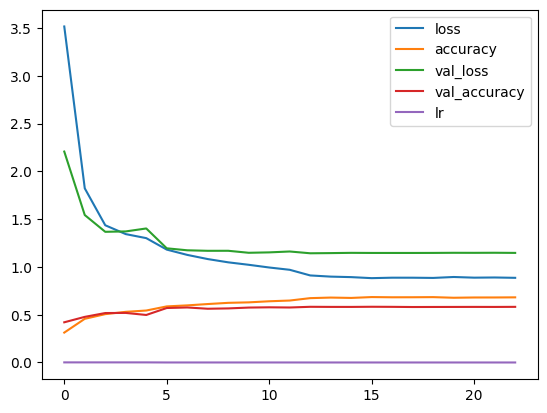

In [13]:
import pandas as pd
pd.DataFrame(history.history).plot();

# Compare Metrics

## Load Models From Drive

In [22]:
from keras.models import load_model
from google.colab import drive
drive.mount('/content/gdrive')

# Load the trained model
loaded_model8 = load_model('/content/gdrive/MyDrive/trained8_model2.h5')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [23]:
from keras.models import load_model

# Load the trained model
loaded_model4 = load_model('/content/gdrive/MyDrive/trained4_model3.h5')


In [26]:
from keras.models import load_model

# Load the trained model
loaded_model2 = load_model('/content/gdrive/MyDrive/trained2_model4.h5')


In [27]:
from keras.models import load_model

# Load the trained model
loaded_model0 = load_model('/content/gdrive/MyDrive/trained0_model5.h5')

## Print Metrics

In [28]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, confusion_matrix


# Get model predictions
y_pred = loaded_model8.predict(X_test_loaded)

# Convert predicted probabilities to class labels
y_pred_classes = np.argmax(y_pred, axis=1)

# Convert true labels to class labels
y_true_classes = np.argmax(y_test_loaded, axis=1)

# Calculate precision and recall
precision = precision_score(y_true_classes, y_pred_classes, average='weighted')
recall = recall_score(y_true_classes, y_pred_classes, average='weighted')

# Print precision and recall
print("Precision:", precision)
print("Recall:", recall)

# print the confusion matrix
conf_mat = confusion_matrix(y_true_classes, y_pred_classes)
print("Confusion Matrix:")
print(conf_mat)


177/177 [==============================] - 1s 4ms/step
Precision: 0.5604191778890987
Recall: 0.5483584738243124
Confusion Matrix:
[[ 935    2  250    8   11   21   24]
 [   6   12   14    0    8    1   13]
 [ 114    0 1297   14   53   38   45]
 [  21    0  117  184   11   45   25]
 [  46    3  457   17  238   45   79]
 [  92    3  350   71   80  201   87]
 [  36    4  254    7   46   27  223]]


In [29]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, confusion_matrix


# Get model predictions
y_pred = loaded_model4.predict(X_test_loaded)

# Convert predicted probabilities to class labels
y_pred_classes = np.argmax(y_pred, axis=1)

# Convert true labels to class labels
y_true_classes = np.argmax(y_test_loaded, axis=1)

# Calculate precision and recall
precision = precision_score(y_true_classes, y_pred_classes, average='weighted')
recall = recall_score(y_true_classes, y_pred_classes, average='weighted')

# Print precision and recall
print("Precision:", precision)
print("Recall:", recall)

# print the confusion matrix
conf_mat = confusion_matrix(y_true_classes, y_pred_classes)
print("Confusion Matrix:")
print(conf_mat)


177/177 [==============================] - 1s 6ms/step
Precision: 0.5397184821100021
Recall: 0.543921916592724
Confusion Matrix:
[[ 928    3  221   10   19   44   26]
 [   4   14    6    0    9    2   19]
 [ 128    0 1141   19  129   63   81]
 [  28    0   78  189   17   61   30]
 [  47    3  341   17  286   98   93]
 [  97    4  256   63  101  251  112]
 [  37    3  198   15   51   37  256]]


In [30]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, confusion_matrix



# Get model predictions
y_pred = loaded_model2.predict(X_test_loaded)

# Convert predicted probabilities to class labels
y_pred_classes = np.argmax(y_pred, axis=1)

# Convert true labels to class labels
y_true_classes = np.argmax(y_test_loaded, axis=1)

# Calculate precision and recall
precision = precision_score(y_true_classes, y_pred_classes, average='weighted')
recall = recall_score(y_true_classes, y_pred_classes, average='weighted')

# Print precision and recall
print("Precision:", precision)
print("Recall:", recall)

# print the confusion matrix
conf_mat = confusion_matrix(y_true_classes, y_pred_classes)
print("Confusion Matrix:")
print(conf_mat)


177/177 [==============================] - 1s 6ms/step
Precision: 0.5239570317111274
Recall: 0.5174800354924578
Confusion Matrix:
[[ 859    4  215   10   25   59   79]
 [   3   12    6    1    5    1   26]
 [ 106    1 1074   21  134   60  165]
 [  27    0   75  170   16   72   43]
 [  43    3  287   20  290   68  174]
 [  82    5  243   73  117  225  139]
 [  24    5  156   27   59   40  286]]


In [31]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, confusion_matrix

# Assuming you have a trained model named model_2
# Assuming you have test data X_test and true labels y_test

# Get model predictions
y_pred = loaded_model0.predict(X_test_loaded)

# Convert predicted probabilities to class labels
y_pred_classes = np.argmax(y_pred, axis=1)

# Convert true labels to class labels
y_true_classes = np.argmax(y_test_loaded, axis=1)

# Calculate precision and recall
precision = precision_score(y_true_classes, y_pred_classes, average='weighted')
recall = recall_score(y_true_classes, y_pred_classes, average='weighted')

# Print precision and recall
print("Precision:", precision)
print("Recall:", recall)

# print the confusion matrix
conf_mat = confusion_matrix(y_true_classes, y_pred_classes)
print("Confusion Matrix:")
print(conf_mat)


177/177 [==============================] - 2s 7ms/step
Precision: 0.5755369925182254
Recall: 0.5822537710736468
Confusion Matrix:
[[ 978    3  151   13   26   58   22]
 [   5   19    8    0    6    3   13]
 [ 130    0 1081   19  168   89   74]
 [  26    0   42  226   10   83   16]
 [  44    4  262   16  384  108   67]
 [  79   12  197   71  119  337   69]
 [  31    6  146   14   80   64  256]]
